In [1]:
import numpy as np
import sympy as sm
import scipy as sp
import pandas as pd
from ggplot import *
from itertools import product
from matplotlib.axes._axes import _log as matplotlib_axes_logger

matplotlib_axes_logger.setLevel('ERROR')

In [2]:
elementsData = dict()
elementsChars = ['H', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'mu', 'sigma', 'epsil']
elements = ['AlCl', 'AlCl2', 'AlCl3', 'GaCl', 'GaCl2', 'GaCl3', 'NH3', 'H2', 'HCl', 'N2', 'Al', 'Ga', 'AlN', 'GaN']

dataFile = open('data.txt', 'r')
lines = dataFile.readlines()
for line in lines:
    dataArr = line.rstrip().split(';')
    elementsData[dataArr[0]] = dict()
    for i in range(0, len(dataArr) - 1):
        elementsData[dataArr[0]][elementsChars[i]] = float(dataArr[i + 1])

In [3]:
R = 8.314  # Дж/(кмоль⋅К) - универсальная газовая постоянная
P_a = 100000  # Па – полное давление

In [4]:
'''
d - коэффициент диффузии (м2/сек)
compIndex - название элемента
temperature - температура
pressure - полное давление в системе (P_i_g - P_i_e)
'''
def d(compIndex, temperature, pressure):
    numerator = 2.628 * 10 ** (-2) * temperature ** (3 / 2)

    dataForIndex = elementsData[compIndex]
    dataForN2 = elementsData['N2']

    sigma = (dataForIndex['sigma'] + dataForN2['sigma']) / 2
    epsil = (dataForIndex['epsil'] * dataForN2['epsil']) ** (1 / 2)
    mu = (2 * dataForIndex['mu'] * dataForN2['mu']) / (dataForIndex['mu'] + dataForN2['mu'])
    omega = 1.074 * (temperature / epsil) ** (-0.1604)

    return numerator / (pressure * sigma * omega * mu ** (1 / 2))

"""
phi нужно для расчета энергии Гиббса (G)
compIndex - название элемента
temperature - температура
"""
def phi(compIndex, temperature):
    dataForIndex = elementsData[compIndex]

    x = temperature / 10 ** 4
    return dataForIndex['f1'] + \
           dataForIndex['f2'] * np.log(x) + \
           dataForIndex['f3'] / x ** 2 + \
           dataForIndex['f4'] / x + \
           dataForIndex['f5'] * x + \
           dataForIndex['f6'] * x ** 2 + \
           dataForIndex['f7'] * x ** 3
"""
g - Энергия Гиббса
compIndex - название элемента
temperature - температура
"""
def g(compIndex, temperature):
    dataForIndex = elementsData[compIndex]
    return dataForIndex['H'] - phi(compIndex, temperature) * temperature


In [5]:
# Коэффициенты для первого задания
def k1(temperature):
    g1Diff = 2 * g('Al', temperature) + 2 * g('HCl', temperature) - 2 * g('AlCl', temperature) - g('H2', temperature)
    return np.exp(-g1Diff / (R * temperature)) / P_a

def k2(temperature):
    g2Diff = g('Al', temperature) + 2 * g('HCl', temperature) - g('AlCl2', temperature) - g('H2', temperature)
    return np.exp(-g2Diff / (R * temperature))

def k3(temperature):
    g3Diff = g('Al', temperature) - 2 * g('AlCl3', temperature) - 3 * g('H2', temperature) + 6 * g('HCl', temperature)
    return np.exp(-g3Diff / (R * temperature)) * P_a

# Коэффициенты для второго задания
def k4(temperature):
    g4Diff = g('Ga', temperature) + 2 * g('HCl', temperature) - 2 * g('GaCl', temperature) - g('H2', temperature)
    return np.exp(-g4Diff / (R * temperature)) / P_a

def k5(temperature):
    g5Diff = g('GaCl2', temperature) + g('H2', temperature) - 2 * g('HCl', temperature) - g('Ga', temperature)
    return np.exp(g5Diff / (R * temperature))

def k6(temperature):
    g6Diff = 2 * g('GaCl3', temperature) + 3 * g('H2', temperature) - 6 * g('HCl', temperature) - 2 * g('Ga', temperature)
    return np.exp(g6Diff / (R * temperature)) * P_a

# Коэффициенты для третьего задания
def k9(temperature):
    g9Diff = g('AlCl3', temperature) + g('NH3', temperature) - g('AlN', temperature) - 3 * g('HCl', temperature)
    return np.exp(-g9Diff / (R * temperature)) / P_a

def k10(temperature):
    g10Diff = g('GaCl', temperature) + g('NH3', temperature) - g('HCl', temperature) - g('H2', temperature) - g('GaN', temperature)
    return np.exp(-g10Diff / (R * temperature))

In [6]:
def newton_method(system, variables):
    jacobian = sm.lambdify(variables, system.jacobian(variables))
    system = sm.lambdify(variables, system)
    
    x = np.random.uniform(0.1, 1., len(variables)).tolist()
    eps = 1e-9
    LIMIT = 1e5
    delta = 1
    steps = 0
    while np.linalg.norm(delta) > eps and steps < LIMIT:
        delta = sp.linalg.lu_solve(sp.linalg.lu_factor(jacobian(*x)), -system(*x))
        x = delta.flatten() + x
        steps += 1
    return x

# Задание №1

**Система:**


(P<sub>HCl</sub>)<sup>2</sup> - K<sub>1</sub> $(P$<sub>AlCl</sub>)<sup>2</sup>P<sub>H2</sub> = 0

(P<sub>HCl</sub>)<sup>2</sup> - K<sub>2</sub> (P<sub>AlCl2</sub>)<sup>2</sup>P<sub>H2</sub> = 0

(P<sub>HCl</sub>)<sup>6</sup> - K<sub>3</sub> (P<sub>AlCl3</sub>)<sup>2</sup>(P<sub>H2</sub>)<sup>3</sup> = 0


D<sub>HCl</sub>(Pg<sub>HCl</sub> - P<sub>HCl</sub>) + 2D<sub>H2</sub>(Pg<sub>H2</sub> - P<sub>H2</sub>) = 0

D<sub>AlCl</sub>(Pg<sub>AlCl</sub> - P<sub>AlCl</sub>) + 2D<sub>AlCl2</sub>(Pg<sub>AlCl2</sub> - P<sub>AlCl2</sub>) + 3D<sub>AlC3</sub>(Pg<sub>AlCl3</sub> - P<sub>AlCl3</sub>) + D<sub>HCl</sub>(Pg<sub>HCl</sub> - P<sub>HCl</sub>) = 0


На каждом шаге для температур $T = 350\dots650℃$ с шагом $dT = 10℃$ производится решение данной СНУ, 

Такое решение даёт требуемые термодинамические давления, а с помощью формулы

$G_i = D_i \cdot (P^g_{i} - P^e_{i}) / RT\delta$

находятся межфазные потоки активных компонент. Далее по формуле

$ V_{Al} = (G_{AlCl} + G_{AlCl2} + G_{AlCl3}) (\mu_{Al} / \rho_{Al}) * 10^9$

находится скорость испарения алюминиевого источника.

In [7]:
"""
Парциальные давления компонент вне диффузионного пограничного слоя (Па) из условия заданий №1 и №2
"""
pg = { 'GaCl' : 0, 'GaCl2' : 0, 'GaCl3' : 0, 
       'AlCl' : 0, 'AlCl2' : 0, 'AlCl3' : 0, 
       'H2' : 0, 'N2' : 90000.0, 'HCl' : 10000.0 
     }

def system1(T):
    p_AlCl, p_AlCl2, p_AlCl3, p_HCl, p_H2 = sm.symbols('p_AlCl, p_AlCl2, p_AlCl3, p_HCl, p_H2')
    p = pg['N2'] + pg['HCl']
    d_HCl = d('HCl', T, p)
    d_H2 = d('H2', T, p)
    d_AlCl = d('AlCl', T, p)
    d_AlCl2 = d('AlCl2', T, p)
    d_AlCl3 = d('AlCl3', T, p)
    equations = []
    equations.append(p_HCl ** 2 - k1(T) * p_AlCl ** 2 * p_H2)
    equations.append(p_HCl ** 2 - k2(T) * p_AlCl2 * p_H2)
    equations.append(p_HCl ** 6 - k3(T) * p_AlCl3 ** 2 * p_H2 ** 3)
    equations.append(d_HCl * (pg['HCl'] - p_HCl) + 2 * d_H2 * (pg['H2'] - p_H2))
    equations.append(d_AlCl * (pg['AlCl2'] - p_AlCl) + 
                     2 * d_AlCl2 * (pg['AlCl2'] - p_AlCl2) +
                     3 * d_AlCl3 * (pg['AlCl3'] - p_AlCl3)  +
                     d_HCl * (pg['HCl'] - p_HCl))
    system = sm.Matrix(equations)
    return system, (p_AlCl, p_AlCl2, p_AlCl3, p_HCl, p_H2)

In [8]:
temperatures = np.linspace(350, 650, 60) + 273
delta = 0.01
p = pg['HCl'] + pg['N2']
data_for_temperature = pd.DataFrame(columns=['T_', 'V_Al', 'G_AlCl', 'G_AlCl2', 'G_AlCl3'])
targets = ['AlCl', 'AlCl2', 'AlCl3']
for k, T in (enumerate(temperatures)):
    system, variables = system1(T)
    solution = newton_method(system, variables)
    # G for elements
    G = {}
    pe = dict(zip(map(str, variables), solution))
    for gasIndex in targets:
        G[gasIndex] = d(gasIndex, T, p) * (pg[gasIndex] - pe['p_' + gasIndex]) / (R * T * delta)
    density_Al = 2690
    mu_Al = elementsData['Al']['mu']
    V_Al = (G['AlCl'] + G['AlCl2'] + G['AlCl3']) * (mu_Al / density_Al) * 1e9
    data_for_temperature.loc[k] = {
        'T_': T,
        'V_Al': V_Al,
        'G_AlCl': G['AlCl'],
        'G_AlCl2': G['AlCl2'],
        'G_AlCl3': G['AlCl3'],
    }

In [9]:
data_for_temperature['invT'] = 1 / data_for_temperature.T_
data_for_temperature['G_AlCl_log'] = np.log(np.abs(data_for_temperature.G_AlCl))
data_for_temperature['G_AlCl2_log'] = np.log(np.abs(data_for_temperature.G_AlCl2))
data_for_temperature['G_AlCl3_log'] = np.log(np.abs(data_for_temperature.G_AlCl3))
data_for_temperature['V_Al_log'] = np.log(np.abs(data_for_temperature.V_Al))

graph_data_comps = pd.melt(data_for_temperature[['invT', 'G_AlCl_log', 
                                      'G_AlCl2_log', 'G_AlCl2_log', 'G_AlCl3_log']], id_vars=['invT'])
graph_data_speed = pd.melt(data_for_temperature[['invT', 'V_Al_log']], id_vars=['invT'])

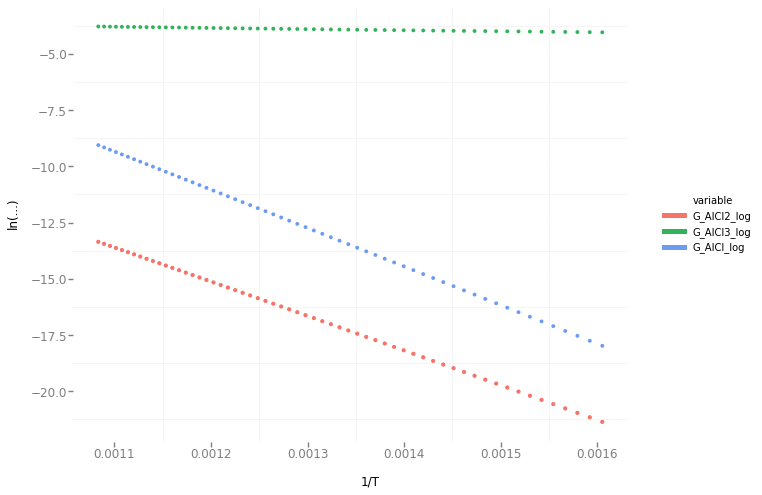

<ggplot: (305423424)>

In [10]:
(ggplot(aes(x = 'invT', y = 'value', color='variable'), graph_data_comps) + 
    geom_point(size=15) + 
    ylab('ln(...)') + 
    xlab('1/T') + 
    theme_bw()
)

Из этого можно делать вывод, что преобладающим Al-содержащим компонентом является AlCl<sub>3</sub>.

Также установим зависимость скорости испарения источника алюминия V<sub>Al</sub><sup>e</sup> в зависимости от $1/T$.

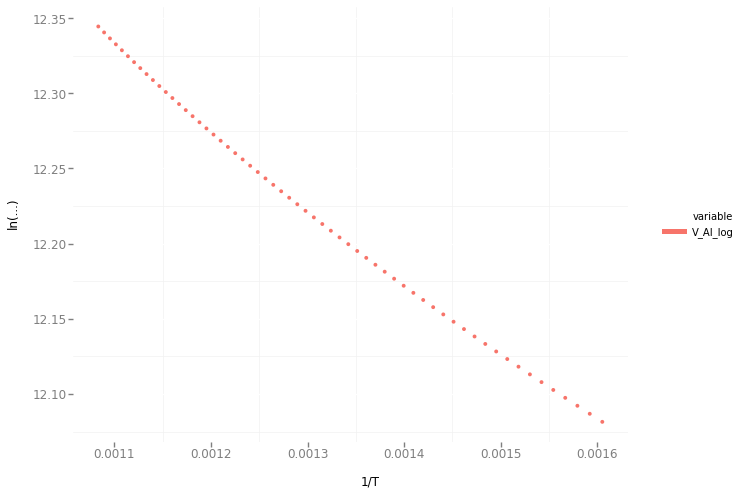

<ggplot: (305423515)>

In [11]:
(ggplot(aes(x = 'invT', y = 'value', color='variable'), graph_data_speed) + 
    geom_point(size=15) + 
    ylab('ln(...)') + 
    xlab('1/T') + 
    theme_bw()
)

# Задание №2


**Система:**


(P<sub>HCl</sub>)<sup>2</sup> = K<sub>4</sub> (P<sub>GaCl</sub>)<sup>2</sup>P<sub>H2</sub> = 0

(P<sub>HCl</sub>)<sup>2</sup> = K<sub>5</sub> P<sub>GaCl2</sub>P<sub>H2</sub> = 0

(P<sub>HCl</sub>)<sup>6</sup> = K<sub>6</sub> (P<sub>GaCl3</sub>)<sup>2</sup>(P<sub>H2</sub>)<sup>3</sup> = 0


D<sub>HCl</sub>(Pg<sub>HCl</sub> - P<sub>HCl</sub>) + 2D<sub>H2</sub>(Pg<sub>H2</sub> - P<sub>H2</sub>) = 0

D<sub>GaCl</sub>(Pg<sub>GaCl</sub> - P<sub>GaCl</sub>) + 2D<sub>GaCl2</sub>(Pg<sub>GaCl2</sub> - P<sub>GaCl2</sub>) + 3D<sub>GaC3</sub>(Pg<sub>GaCl3</sub> - P<sub>GaCl3</sub>) + D<sub>HCl</sub>(Pg<sub>HCl</sub> - P<sub>HCl</sub>) = 0

На каждом шаге для температур $T = 350\dots650℃$ с шагом $dT = 10℃$ производится решение данной СНУ, 

Такое решение даёт требуемые термодинамические давления, а с помощью формулы

$G_i = D_i \cdot (P^g_{i} - P^e_{i}) / RT\delta$

находятся межфазные потоки активных компонент. Далее по формуле

$ V_{Ga} = (G_{GaCl} + G_{GaCl_2} + G_{GaCl_3}) (\mu_{Ga} / \rho_{Ga}) * 10^9$

находится скорость испарения источника галлия.

In [9]:
def system2(T):
    p_GaCl, p_GaCl2, p_GaCl3, p_HCl, p_H2 = sm.symbols('p_GaCl, p_GaCl2, p_GaCl3, p_HCl, p_H2')
    p = pg['N2'] + pg['HCl']
    d_HCl = d('HCl', T, p)
    d_H2 = d('H2', T, p)
    d_GaCl = d('GaCl', T, p)
    d_GaCl2 = d('GaCl2', T, p)
    d_GaCl3 = d('GaCl3', T, p)
    equations = []
    equations.append(p_HCl ** 2 - k4(T) * p_GaCl ** 2 * p_H2)
    equations.append(p_HCl ** 2 - k5(T) * p_GaCl2 * p_H2)
    equations.append(p_HCl ** 6 - k6(T) * p_GaCl3 ** 2 * p_H2 ** 3)
    equations.append(d_HCl * (pg['HCl'] - p_HCl) + 2 * d_H2 * (pg['H2'] - p_H2))
    equations.append(d_GaCl  * (pg['GaCl'] - p_GaCl)  + 
                     2 * d_GaCl2 * (pg['GaCl2'] - p_GaCl2) + 
                     3 * d_GaCl3 * (pg['GaCl3'] - p_GaCl3) + 
                     d_HCl * (pg['HCl'] - p_HCl))
    system = sm.Matrix(equations)
    return system, (p_GaCl, p_GaCl2, p_GaCl3, p_HCl, p_H2)

In [10]:
data_for_temperature = pd.DataFrame(columns=['T_', 'V_Ga', 'G_GaCl', 'G_GaCl2', 'G_GaCl3'])
targets = ['GaCl', 'GaCl2', 'GaCl3']
for k, T in (enumerate(temperatures)):
    system, variables = system2(T)
    solution = newton_method(system, variables)
    # G for elements
    G = {}
    pe = dict(zip(map(str, variables), solution))
    for gasIndex in targets:
        G[gasIndex] = d(gasIndex, T, p) * (pg[gasIndex] - pe['p_' + gasIndex]) / (R * T * delta)
    density_Ga = 5900.
    mu_Ga = elementsData['Ga']['mu']
    V_Ga = (G['GaCl'] + G['GaCl2'] + G['GaCl3']) * (mu_Ga / density_Ga) * 1e9
    data_for_temperature.loc[k] = {
        'T_': T,
        'V_Ga': V_Ga,
        'G_GaCl': G['GaCl'],
        'G_GaCl2': G['GaCl2'],
        'G_GaCl3': G['GaCl3']
    }

In [12]:
data_for_temperature['invT'] = 1 / data_for_temperature.T_
data_for_temperature['V_Ga_log'] = np.log(np.abs(data_for_temperature.V_Ga))
data_for_temperature['G_GaCl_log'] = np.log(np.abs(data_for_temperature.G_GaCl))
data_for_temperature['G_GaCl2_log'] = np.log(np.abs(data_for_temperature.G_GaCl2))
data_for_temperature['G_GaCl3_log'] = np.log(np.abs(data_for_temperature.G_GaCl3))
graph_data_comp = pd.melt(data_for_temperature[['invT', 'G_GaCl_log', 
                                      'G_GaCl2_log', 'G_GaCl3_log']], id_vars=['invT'])
graph_data_speed = pd.melt(data_for_temperature[['invT', 'V_Ga_log']], id_vars=['invT'])

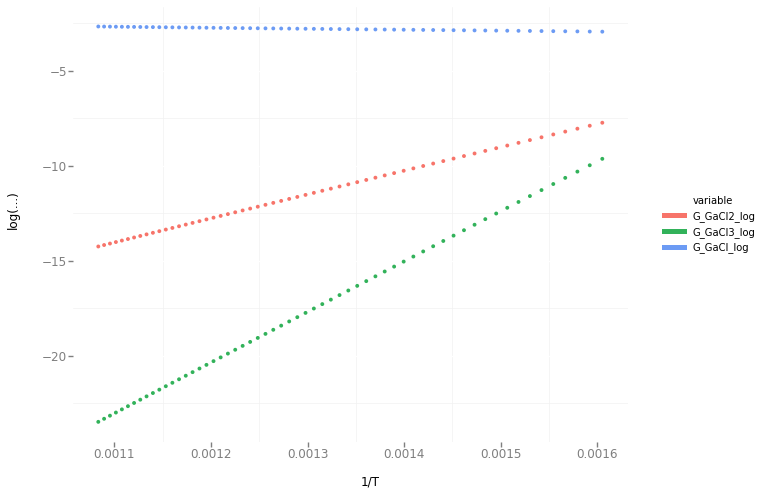

<ggplot: (-9223372036545890581)>

In [32]:
(ggplot(aes(x = 'invT', y = 'value', color='variable'), graph_data_comp) + 
    geom_point(size=15) + 
    ylab('log(...)') + 
    xlab('1/T') + 
    theme_bw()
)

Из этого можно делать вывод, что преобладающим Ga-содержащим компонентом является GaCl.
Также установим зависимость скорости испарения источника галлия V<sub>Ga</sub><sup>e</sup> в зависимости от 1/T.

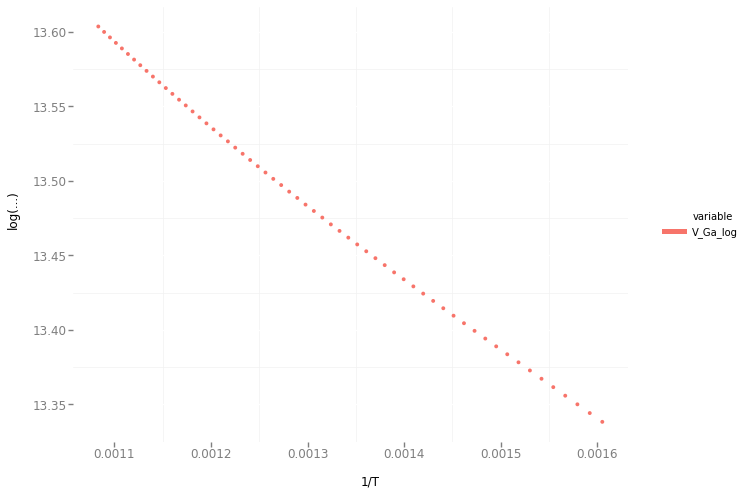

<ggplot: (-9223372036545770436)>

In [33]:
(ggplot(aes(x = 'invT', y = 'value', color='variable'), graph_data_speed) + 
    geom_point(size=15) + 
    ylab('log(...)') + 
    xlab('1/T') + 
    theme_bw()
)

# Задание №3

**Система:**


P<sub>AlCl3</sub>P<sub>NH3</sub> = K<sub>9</sub> x(P<sub>HCl</sub>)<sup>3</sup>P<sub>H2</sub> = 0

P<sub>GaCl</sub>P<sub>NH3</sub> = K<sub>10</sub>(1 - x)P<sub>HCl</sub>P<sub>H2</sub> = 0


D<sub>HCl</sub>(Pg<sub>HCl</sub> - P<sub>HCl</sub>) +
2D<sub>H2</sub>(Pg<sub>H2</sub> - P<sub>H2</sub>) +
3D<sub>NH3</sub>(Pg<sub>NH3</sub> - P<sub>NH3</sub>) = 0

3D<sub>AlCl3</sub>(Pg<sub>AlCl3</sub> - P<sub>AlCl3</sub>) +
D<sub>GaCl</sub>(Pg<sub>GaCl</sub> - P<sub>GaCl</sub>) +
D<sub>HCl</sub>(Pg<sub>HCl</sub> - P<sub>HCl</sub>) = 0

D<sub>AlCl3</sub>(Pg<sub>AlCl3</sub> - P<sub>AlCl3</sub>) +
D<sub>GaCl</sub>(Pg<sub>GaCl</sub> - P<sub>GaCl</sub>) +
D<sub>NH3</sub>(Pg<sub>NH3</sub> - P<sub>NH3</sub>) = 0

D<sub>AlCl3</sub>(Pg<sub>AlCl3</sub> - P<sub>AlCl3</sub>)(1 - x) -
D<sub>GaCl</sub>(Pg<sub>GaCl</sub> - P<sub>GaCl</sub>)x = 0

In [11]:
'''
x_g:[0, 1]
n2Percentage: [0, 1]
    1 and 0.9 by task
'''
def system3(x_g, T, n2Percentage):
    assert (0 <= x_g <= 1), "x_g should be in [0, 1] range"
    assert (0 <= n2Percentage <= 1), "n2Percentage should be in [0, 1] range"
    
    p_AlCl3, p_GaCl, p_NH3, p_HCl, p_H2, x = sm.symbols('p_AlCl3, p_GaCl, p_NH3, p_HCl, p_H2, x')
    pg_AlCl3_GaCl = 30
    pg_N2_H2 = 98470
    pg_NH3 = 1500
    pg_HCl = 0
    pg_N2 = pg_N2_H2 * n2Percentage
    pg_H2 = pg_N2_H2 - pg_N2
    pg_AlCl3 = x_g * pg_AlCl3_GaCl
    pg_GaCl = pg_AlCl3_GaCl - pg_AlCl3
    d_HCl = d('HCl', T, P_a)
    d_H2 = d('H2', T, P_a)
    d_NH3 = d('NH3', T, P_a)
    d_AlCl3 = d('AlCl3', T, P_a)
    d_GaCl = d('GaCl', T, P_a)
    
    equations = []
    equations.append(p_AlCl3 * p_NH3 - k9(T) * x * p_HCl ** 3)
    equations.append(p_GaCl * p_NH3 - k10(T) * (1 - x) * p_HCl * p_H2)
    equations.append(d_HCl * (pg_HCl - p_HCl) + 2 * d_H2 * (pg_H2 - p_H2) + 3 * d_NH3 * (pg_NH3 - p_NH3))
    equations.append(3 * d_AlCl3 * (pg_AlCl3 - p_AlCl3) + d_GaCl * (pg_GaCl - p_GaCl) + d_HCl * (pg_HCl - p_HCl))
    equations.append(d_AlCl3 * (pg_AlCl3 - p_AlCl3) + d_GaCl * (pg_GaCl - p_GaCl) - d_NH3 * (pg_NH3 - p_NH3))
    equations.append(d_AlCl3 * (pg_AlCl3 - p_AlCl3) * (1 - x) - d_GaCl  * (pg_GaCl  - p_GaCl)  * x)
    system = sm.Matrix(equations)
    return system, (p_AlCl3, p_GaCl, p_NH3, p_HCl, p_H2, x)

In [12]:
x_gs = np.linspace(0., 1., 60)
n2Percentages = [1, 0.9]
T = 1100 + 273
pg_AlCl3_GaCl = 30
data_for_temperature = pd.DataFrame(columns=['x_g', 'n2Percentage', 'x', 'V_AlGaN', 'G_GaCl', 'G_AlCl3'])
targets = ['GaCl', 'AlCl3']
for k, (x_g, n2Percentage) in (enumerate(product(x_gs, n2Percentages))):
    x = 2
    while x < 0 or x > 1:
        system, variables = system3(x_g, T, n2Percentage)
        solution = newton_method(system,variables)
        x = solution[-1]
    # G for elements
    G = {}
    pg['AlCl3'] = x_g * pg_AlCl3_GaCl
    pg['GaCl'] = (1 - x_g) * pg_AlCl3_GaCl
    pe = dict(zip(map(str, variables), solution))
    for gasIndex in targets:
        G[gasIndex] = d(gasIndex, T, P_a) * (pg[gasIndex] - pe['p_' + gasIndex]) / (R * T * delta)
    density_AlN = 3200.
    density_GaN = 6150.
    mu_AlN = elementsData['AlN']['mu']
    mu_GaN = elementsData['GaN']['mu']
    V = (G['AlCl3'] * (mu_AlN / density_AlN) + G['GaCl'] * (mu_GaN / density_GaN)) * 1e9
    if V <= 1e5:
        data_for_temperature.loc[k] = {
            'x_g': x_g,
            'n2Percentage': n2Percentage,
            'x': pe['x'],
            'V_AlGaN': V,
            'G_GaCl': G['GaCl'],
            'G_AlCl3': G['AlCl3']
    }

Скорость роста слоя алгана, когда несущий газ - N2:

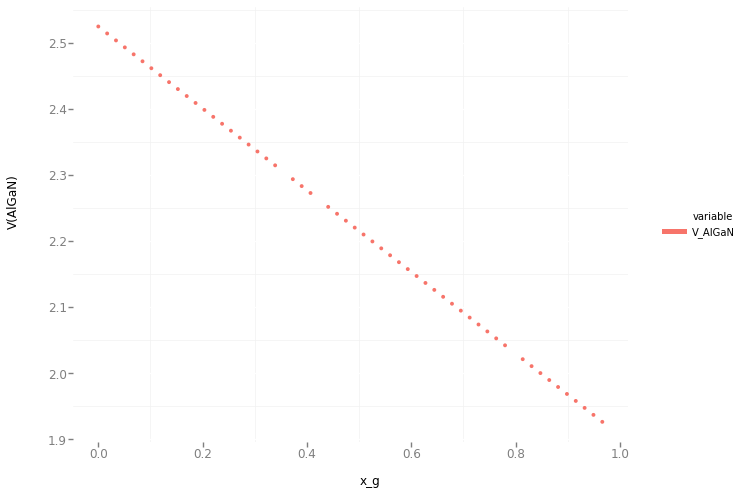

<ggplot: (8746773133008)>

In [13]:
data_for_temperature['V_AlGaN'] = data_for_temperature.V_AlGaN / 1000
graph_data_speed = pd.melt(data_for_temperature[['x_g', 'V_AlGaN', 'n2Percentage']], id_vars=['x_g', 'n2Percentage'])
(ggplot(aes(x = 'x_g', y = 'value', color='variable'), graph_data_speed[graph_data_speed.n2Percentage == 1]) + 
    geom_point(size=15) + 
    ylab('V(AlGaN)') +
    theme_bw()
)

Скорость роста слоя алгана, когда несущий газ - смесь N2 и H2:

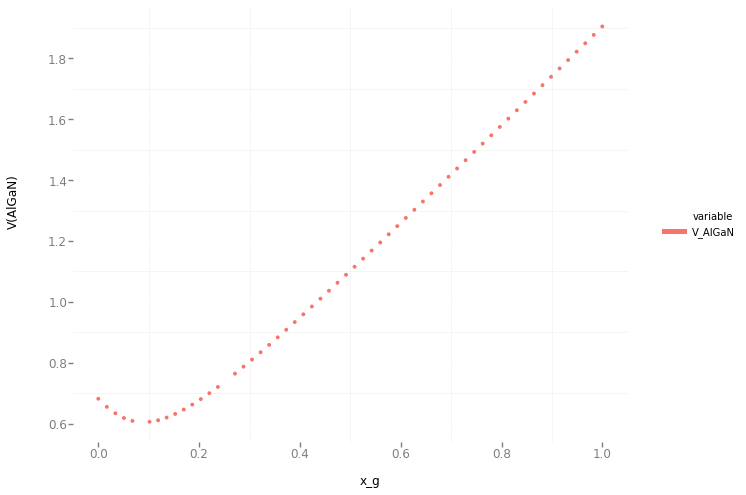

<ggplot: (8746773134740)>

In [14]:
(ggplot(aes(x = 'x_g', y = 'value', color='variable'), graph_data_speed[graph_data_speed.n2Percentage == 0.9]) + 
    geom_point(size=15) + 
    ylab('V(AlGaN)') +
    theme_bw()
)

График вхождения Al в кристалл при различных несущих газах:

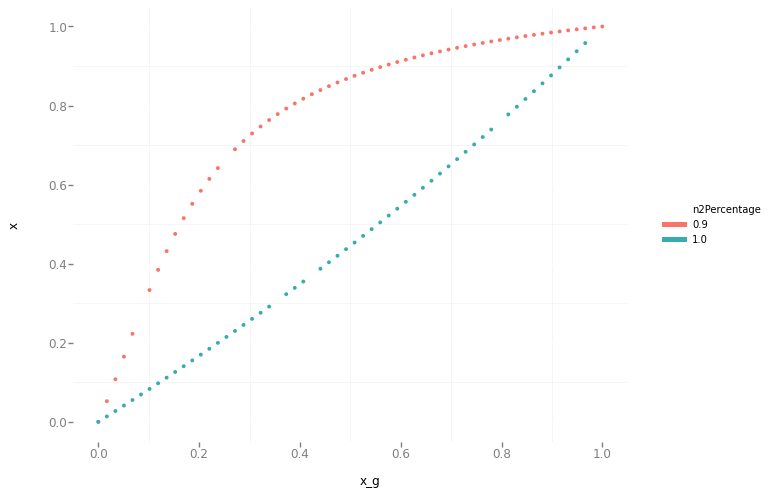

<ggplot: (8746775760906)>

In [15]:
graph_data_fraction = pd.melt(data_for_temperature, id_vars=['x_g', 'n2Percentage'])
graph_data_fraction.n2Percentage = graph_data_fraction.n2Percentage.map(str)
(ggplot(aes(y='value', x='x_g', color='n2Percentage'), data=graph_data_fraction[graph_data_fraction.variable == 'x']) +
     geom_point(size=15) +
     ylab('x') +
     theme_bw()
)